In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import functools 
import fun_eda

Clustering para las rutas obtenidas con change point detection (CPD).
1. Clusters por agebs
2. Clusters por ruta

#### 1. Carga de la información

In [3]:
##### Load datos demograficos por AGEB
DATOS_DEM_AGEB = "~/bj/data/rutas_tiles/demograficos_agebs_2020-09-15.csv"
ageb_data_all = pd.read_csv(DATOS_DEM_AGEB) 
#ageb_data['ageb'] = ageb_data['CVE_AGEB'].astype('str').str.zfill(4)
#ageb_data['coord'] = ageb_data['long'].astype(str) + ' ' + ageb_data['lat'].astype(str)
print("Info demografica por AGEB:", ageb_data_all.shape)
#ageb_data.head(5)

##### Load datos de unidades economicas y rezago social por ageb
DATOS_UE_AGEB = "~/bj/data/table_3_por_ageb.pkl"
ageb_dataUE = pd.read_pickle(DATOS_UE_AGEB) 
ageb_dataUE.drop(columns=['cve_ent', 'entidad', 'cve_mun', 'municipio','cve_loc', 'localidad', 'Clave_de_AGEB' ], inplace=True)
#ageb_dataUE.drop_duplicates(keep='first', inplace=True)
print("Info UE y rezago por AGEB:", ageb_dataUE.shape)


Info demografica por AGEB: (471, 192)
Info UE y rezago por AGEB: (7409, 24)


In [4]:
#ageb_data_all[(ageb_data_all['POBTOT']==0)|(ageb_data_all['TOTHOG']==0)|(ageb_data_all['VIVTOT']==0)]
# Hay 16 AGEBS que no tienen info de vivienda, hogares, poblacion

In [5]:
# data UE
cols = ageb_dataUE.columns[~ageb_dataUE.columns.isin(['ageb_long', 'ageb','ageb_9_dig' , 'Rango_de_pobreza_(%)', 'Rango_de_pobreza_extrema_(%)'])]
ageb_dataUE.rename(columns =  dict(zip(cols, cols + '_ue')), inplace=True)

ageb_dataUE.insert(22,'ue_totales', ageb_dataUE.iloc[:,1:20].sum(axis='columns'))

print(ageb_dataUE.shape)
#ageb_dataUE.head(5)

(7409, 25)


#### 2. Transformación de variables

Todas las variables demográficas seleccionadas y las referentes a las unidades economicas, se convierten a tasas por cada 10,000 habitantes.
Las variables de Rezago Social que se tienen originalmente en intervalos de porcentajes, se convierten a porcentajes, tomado el punto medio del intervalo.

In [6]:
pob = ['POBTOT', 'POBMAS', 'POBFEM', 'POB0_14', 'POB15_64', 'POB65_MAS', 'P3YM_HLI', 'PSIN_LIM', 'P3A5_NOA', 
       'P6A11_NOAM', 'P12A14NOAM', 'P18A24A_F', 'P8A14AN', 'P15YM_SE', 'GRAPROES', 'PEA', 'PE_INAC', 'POCUPADA',
       'PDESOCUP', 'PSINDER']
hogar = ['TOTHOG', 'HOGJEF_M', 'HOGJEF_F', 'PHOGJEF_M', 'PHOGJEF_F']

viviendas = ['PROM_OCUP', 'PRO_OCUP_C', 'VPH_PISOTI', 'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_S_ELEC',
             'VPH_AGUAFV', 'VPH_NODREN', 'VPH_AUTOM', 'VPH_PC', 'VPH_INTER', 'VPH_TELEF']

# tasa por 10,000 habs
NHABS = 10000

#### Caracteristicas de la poblacion
ageb_data = ageb_data_all[['id_ageb_ent', 'VIVTOT' ] + pob + hogar + viviendas].copy()
# Ratios
ageb_data['ratio_pob_m_h'] = ageb_data['POBFEM']/ageb_data['POBMAS']
ageb_data['ratio_pea_inac'] = ageb_data['PEA']/ageb_data['PE_INAC']
ageb_data['ratio_ocup_desocup'] = ageb_data['POCUPADA']/ageb_data['PDESOCUP']
pob = list(set(pob).difference({'POBMAS', 'POBFEM', 'PEA', 'PE_INAC', 'POCUPADA', 'PDESOCUP'}))
# Tasas
ageb_data[pob] = (ageb_data[pob]*NHABS).div(ageb_data['POBTOT'], axis=0)

#### Hogares
ageb_data['ratio_hjefeF_hjefeM'] = ageb_data['HOGJEF_F']/ageb_data['HOGJEF_M'] #numero de hogares con jefatura
ageb_data['ratio_pobhjefeF_pobhjefeM'] = ageb_data['PHOGJEF_F']/ageb_data['PHOGJEF_M'] #poblacion en hogares con jefatura
ageb_data['tasa_hogares'] = (ageb_data['TOTHOG']*NHABS).div(ageb_data['POBTOT'], axis=0)

#### Viviendas
ageb_data['VPH_PC_INTER'] = ageb_data[['VPH_PC', 'VPH_INTER']].sum(axis=1)
ageb_data['VPH_TELEF_INTER'] = ageb_data[['VPH_INTER', 'VPH_TELEF']].sum(axis=1)
viviendas = list(set(viviendas).difference({'PROM_OCUP', 'PRO_OCUP_C'}))
ageb_data[viviendas] = (ageb_data[viviendas]*NHABS).div(ageb_data['VIVTOT'], axis=0)

borrar_cols = hogar+['POBMAS', 'POBFEM', 'PEA', 'PE_INAC', 'POCUPADA', 'PDESOCUP','VPH_PC',
                     'VPH_INTER', 'VPH_TELEF', 'VIVTOT', 'POBTOT' ]
ageb_data.drop(columns=borrar_cols, inplace=True)

print(ageb_data.shape)
#ageb_data.head(5)

(471, 32)


In [7]:
## Join info por AGEB
ageb_data = ageb_data.merge(ageb_dataUE, left_on='id_ageb_ent', right_on='ageb_9_dig',  how='left')
print(ageb_data.shape)
#ageb_data.head(5)

(471, 57)


In [8]:
# tasa de unidades economicas por 10,000 habs
cols = ageb_dataUE.columns[ageb_dataUE.columns.str.endswith('_ue')].to_list() + ['ue_totales']
ageb_data[cols] = (ageb_data[cols]*NHABS).div(ageb_data_all['POBTOT'], axis=0)

# Convertimos a valores numericos (%)
ageb_data['Rango_de_pobreza_(%)'] = ageb_data['Rango_de_pobreza_(%)'].map({'[ 0, 18]':9, '(18, 34]':26, '(34, 50]':44 , '(50, 70]':60, '(70, 100]':85, 'Una vivienda particular habitada':0, 'Sin viviendas particulares habitadas':0}, na_action='ignore')
ageb_data['Rango_de_pobreza_extrema_(%)'] = ageb_data['Rango_de_pobreza_extrema_(%)'].map({'[ 0, 20]':10, '(20, 50]':35, 'Una vivienda particular habitada':0, 'Sin viviendas particulares habitadas':0,}, na_action=0)

#ageb_data.drop(columns=['POBTOT', 'VIVTOT'], inplace=True)
print(ageb_data.shape)
#ageb_data.head(5)

(471, 57)


In [9]:
agebs = ageb_data['id_ageb_ent']
ageb_data.drop(columns=['id_ageb_ent', 'ageb_long', 'ageb', 'ageb_9_dig'], inplace=True)
#ageb_data

In [10]:
# Eliminamos los renglones que se componen solo de NaN o ceros o Inf
del_index = ageb_data[(ageb_data == np.inf).any(axis=1)].index
ageb_data.drop(index=del_index, inplace=True)
agebs.drop(index=del_index, inplace=True)

In [11]:
ageb_data.drop(columns=['id_ageb_ent'], inplace = True)

In [12]:
ageb_data.rename(columns={'Generacion,_transmision,_distribucion_y_comercializacion_de_energia_electrica,_suministro_de_agua_y_de_gas_natural_por_ductos_al_consumidor_final_ue':'Electricidad_ue',
       'Servicios_de_alojamiento_temporal_y_de_preparacion_de_alimentos_y_bebidas_ue':'Alimentos_y_bebidas_ue',
       'Servicios_de_apoyo_a_los_negocios_y_manejo_de_residuos,_y_servicios_de_remediacion_ue':'Manejo_residuos_ue',
       'Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos_ue':'Esparcimiento_ue',
       'Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue':'Inmobiliarios_y_bienes_muebles_ue', 
       'Agricultura,_cria_y_explotacion_de_animales,_aprovechamiento_forestal,_pesca_y_caza_ue':'Agricultura_ue',
       'Otros_servicios_excepto_actividades_gubernamentales_ue':'Otros_servicios_ue',
       'Servicios_profesionales,_cientificos_y_tecnicos_ue':'Servicios_profesionales_tecnicos_ue'}, inplace=True)

In [13]:
## Base final
print("Base final", ageb_data.shape)
ageb_data.round(2)

Base final (429, 53)


,POB0_14,POB15_64,POB65_MAS,P3YM_HLI,PSIN_LIM,P3A5_NOA,P6A11_NOAM,P12A14NOAM,P18A24A_F,P8A14AN,...,Esparcimiento_ue,Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Inmobiliarios_y_bienes_muebles_ue,Servicios_profesionales_tecnicos_ue,"Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
0,3269.71,6459.20,229.60,208.85,9585.06,295.99,24.90,41.49,149.38,53.94,...,1.38,0.00,1.38,17.98,1.38,0.00,1.38,120.33,60.0,10.0
2,2377.13,6961.25,567.11,42.53,8941.40,155.95,0.00,0.00,184.31,0.00,...,42.53,14.18,42.53,37.81,4.73,9.45,9.45,614.37,0.0,0.0
4,3235.39,6203.07,514.20,2468.17,9588.64,452.17,9.79,8.16,148.55,14.69,...,3.26,9.79,9.79,0.00,0.00,1.63,0.00,411.36,0.0,0.0
5,3627.89,5858.27,217.39,48.00,9463.58,389.61,8.47,42.35,50.82,0.00,...,2.82,2.82,5.65,0.00,5.65,5.65,0.00,268.21,85.0,10.0
6,2848.77,6521.60,611.11,67.90,9808.64,274.69,27.78,9.26,141.98,12.35,...,9.26,3.09,12.35,24.69,3.09,0.00,18.52,614.20,60.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,2815.93,6519.03,343.36,196.40,9240.15,365.03,8.80,14.22,146.28,27.09,...,1.35,4.06,5.42,0.00,1.35,1.35,0.00,224.84,44.0,10.0
465,2793.79,6563.19,210.64,121.95,8669.62,77.61,0.00,0.00,188.47,0.00,...,0.00,11.09,22.17,33.26,0.00,0.00,0.00,543.24,44.0,10.0
468,639.87,9155.20,174.32,168.49,9788.95,55.97,2.33,2.62,57.14,2.33,...,0.87,0.87,1.17,1.46,0.00,2.62,0.00,51.31,26.0,10.0
469,3005.62,6348.31,603.93,98.31,9410.11,245.79,0.00,0.00,126.40,0.00,...,0.00,21.07,7.02,7.02,0.00,21.07,0.00,316.01,60.0,10.0


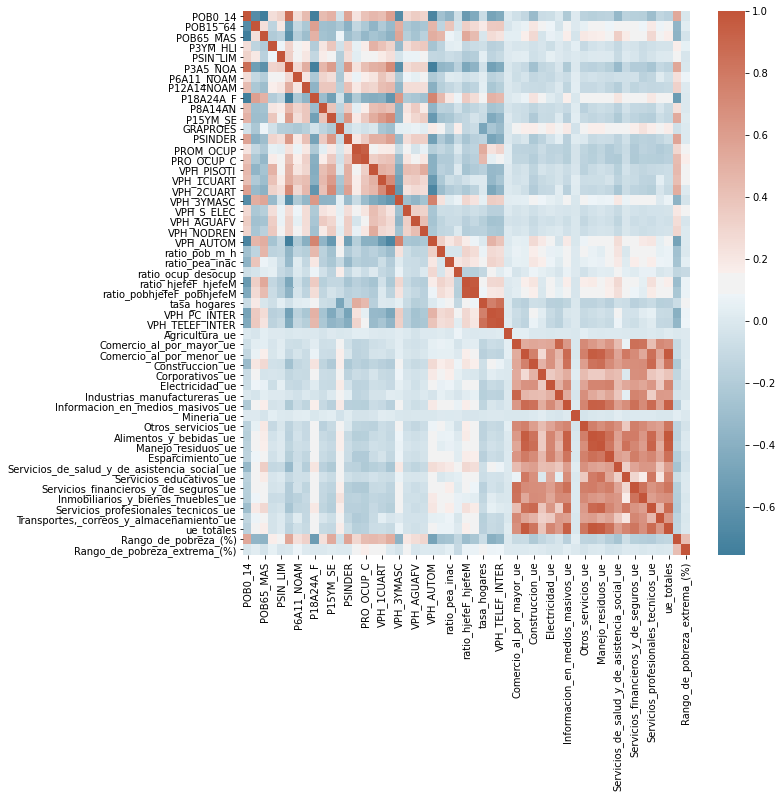

In [14]:
plt.figure(figsize=(10,10))
corr_matrix = ageb_data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=False, cmap=cmap)

In [15]:
pd.set_option('display.max_columns', 210)
fun_eda.descriptive_stats_for_numeric_vars(ageb_data, ageb_data.columns)

,POB0_14,POB15_64,POB65_MAS,P3YM_HLI,PSIN_LIM,P3A5_NOA,P6A11_NOAM,P12A14NOAM,P18A24A_F,P8A14AN,P15YM_SE,GRAPROES,PSINDER,PROM_OCUP,PRO_OCUP_C,VPH_PISOTI,VPH_1CUART,VPH_2CUART,VPH_3YMASC,VPH_S_ELEC,VPH_AGUAFV,VPH_NODREN,VPH_AUTOM,ratio_pob_m_h,ratio_pea_inac,ratio_ocup_desocup,ratio_hjefeF_hjefeM,ratio_pobhjefeF_pobhjefeM,tasa_hogares,VPH_PC_INTER,VPH_TELEF_INTER,Agricultura_ue,Comercio_al_por_mayor_ue,Comercio_al_por_menor_ue,Construccion_ue,Corporativos_ue,Electricidad_ue,Industrias_manufactureras_ue,Informacion_en_medios_masivos_ue,Mineria_ue,Otros_servicios_ue,Alimentos_y_bebidas_ue,Manejo_residuos_ue,Esparcimiento_ue,Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Inmobiliarios_y_bienes_muebles_ue,Servicios_profesionales_tecnicos_ue,"Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
n_observations,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,424.000000,424.000000
max,4003.250271,9155.200560,1784.655300,2468.168462,9878.254988,509.941090,69.324090,56.753689,471.910112,98.360656,1047.016616,1982.369942,7888.707038,836.590000,209.880000,2338.926174,3857.142857,4163.133229,9069.373942,746.527778,8893.485005,4659.231722,8348.314607,1.426948,5.703390,265.200000,1.167086,1.063699,12310.000000,12140.000000,12997.000000,1.353913,1197.183099,4839.285714,53.571429,22.123894,35.714286,1056.338028,107.142857,16.782278,598.591549,3000.000000,678.571429,140.845070,149.621546,2446.428571,1250.000000,140.845070,428.571429,248.756219,12428.571429,85.000000,35.000000
min,639.867071,5048.780488,0.000000,0.000000,6420.183893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.503025,36.063885,6.500000,1.720000,0.000000,0.000000,0.000000,1146.469050,0.000000,0.000000,0.000000,365.551425,0.142215,0.443225,3.595855,0.034232,0.022663,90.000000,7.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.070310,0.000000,0.000000
mean,2682.117197,6603.522383,497.878042,156.896696,9368.088996,219.843224,7.208029,7.951242,183.737104,12.322602,240.052744,414.038802,4064.925078,130.016270,35.145524,206.808703,570.812406,1314.078090,6321.270757,17.449772,657.718282,157.449359,3687.793715,1.056713,1.248966,31.942651,0.314751,0.270869,2356.477855,1621.962704,2093.041958,0.012033,15.402731,149.835629,1.026849,0.162089,0.917366,30.498686,1.592949,0.056723,39.936739,50.542698,7.901300,4.453304,10.041782,13.985528,15.601652,3.947608,6.478256,3.681072,345.915666,38.165094,9.610849
std_dev,574.029701,405.151184,295.597776,218.809195,379.161135,108.672859,7.838377,7.621730,80.248461,14.116592,143.059730,246.831200,1247.648142,72.458347,21.717848,286.504589,488.372823,756.621568,1239.412685,65.101755,1455.581289,476.698621,1475.472878,0.095752,0.309930,29.076451,0.128203,0.113006,1601.438665,1697.943298,1899.051428,0.113815,64.408311,288.296661,3.782184,1.497991,3.098494,62.857422,7.451485,0.825214,41.192018,182.710831,38.299576,10.822506,15.301454,118.211438,76.430134,8.975745,25.242838,16.450001,799.792700,23.812628,3.753892
25%,2372.077636,6385.861102,304.795448,51.995320,9292.185730,145.288501,0.000000,2.638871,130.477597,3.264063,143.805310,244.452247,3185.384280,84.530000,19.430000,45.248869,199.430199,732.292917,5736.885928,0.000000,5.326705,0.000000,2830.357143,1.020390,1.108184,17.977273,0.241935,0.205718,1

In [16]:
# fill NaN
ageb_data = ageb_data.fillna(0)

# Fill Inf
#cols =  ageb_data.columns[ageb_data.columns.str.endswith('_ue')]
#for col in cols:
#    ageb_data.loc[ageb_data[col] == np.inf, col]=0

#ageb_data.loc[ageb_data['ue_totales'] == np.inf, 'ue_totales']=0

#### 3. K means & Decision tree

Todas mis variables son numericas

In [17]:
import math
from itertools import product
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import tree

In [18]:
def vizs(ageb_data_scaled, kmeans_clusters, best_estimator, X, y):
    fig = plt.figure(figsize=(12, 15))
    grid = plt.GridSpec(2,2)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[1, :])
    sns.set_style("darkgrid")
        
    ##### Visualizacion K-means
    PERPLEXITY=20
    tsne = TSNE(n_components=2, perplexity= PERPLEXITY)
    tsne_components = tsne.fit_transform(ageb_data_scaled)
    TSNE_df = pd.DataFrame(tsne_components)
    TSNE_df.insert(0, 'cluster', kmeans_clusters)

    n=len(set(kmeans_clusters))
    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in list(set(kmeans_clusters))]
    colors =  ('green', 'red', 'blue', 'yellow', 'purple')
    groups = [str(i) for i in list(set(kmeans_clusters))]
    
    for data, group, color in zip(datas, groups, colors):
        #print(len(data), len(color), len(group))
        # cmap=plt.get_cmap('viridis')
        ax2.scatter(data[0], data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax2.set_title(f'clusters:{n}')
        ax2.legend()
    
    ##### Visualizacion relevancia de variables
    clf_best = best_estimator
    clf_best.fit(X, y)
    feature_imp = pd.Series(clf_best.feature_importances_, index=ageb_data.columns).sort_values(ascending=False)

    pp = sns.cubehelix_palette(30, start=.1, rot=-.75, reverse=True)
    sns.barplot(x=feature_imp, y=feature_imp.index, palette=pp, ax=ax1)
    ax1.set_title("Vizualizacion del score de importancia de las variables")
    
    ##### Visualizacion del arbol
    ax3 = tree.plot_tree(clf_best,
               feature_names=ageb_data.columns.to_list(),  
               #class_names=["C0","C1", "C2"],
               filled=True)
    
    plt.show()
    return feature_imp

In [19]:
# scale numeric variables
scaler = StandardScaler()
ageb_data_scaled = scaler.fit_transform(ageb_data)

Accuracy: 0.9090909090909091
Confusion Matrix: 
 [[269  20]
 [ 19 121]]


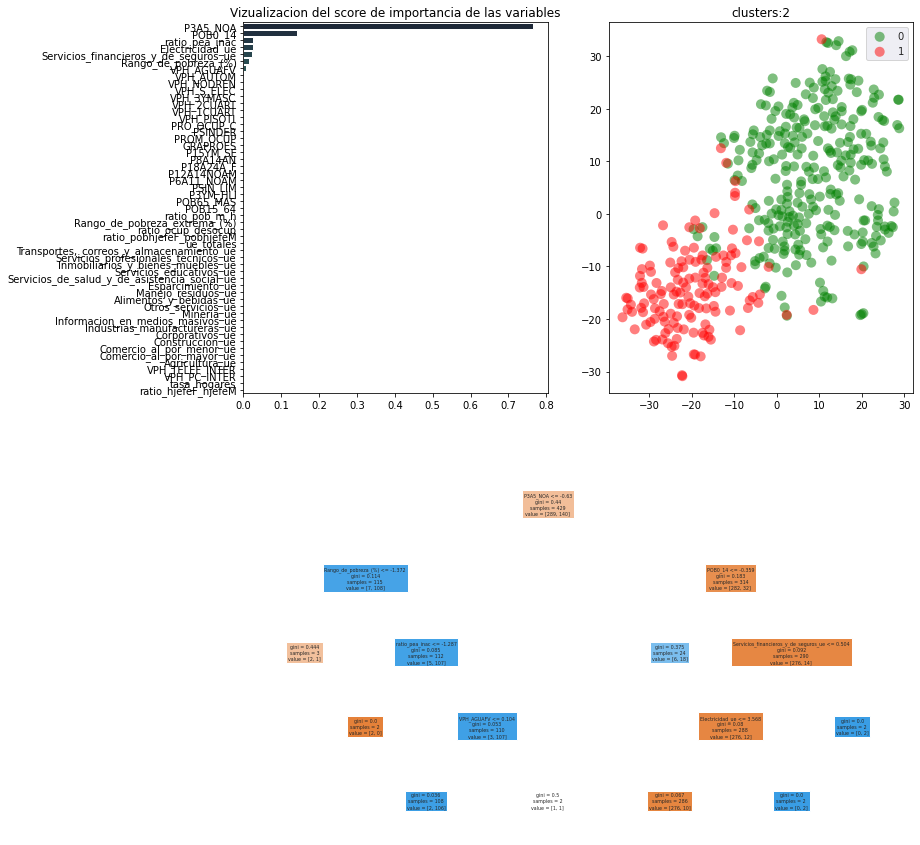

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9347319347319347
Confusion Matrix: 
 [[249  12   0]
 [ 15 151   0]
 [  0   1   1]]


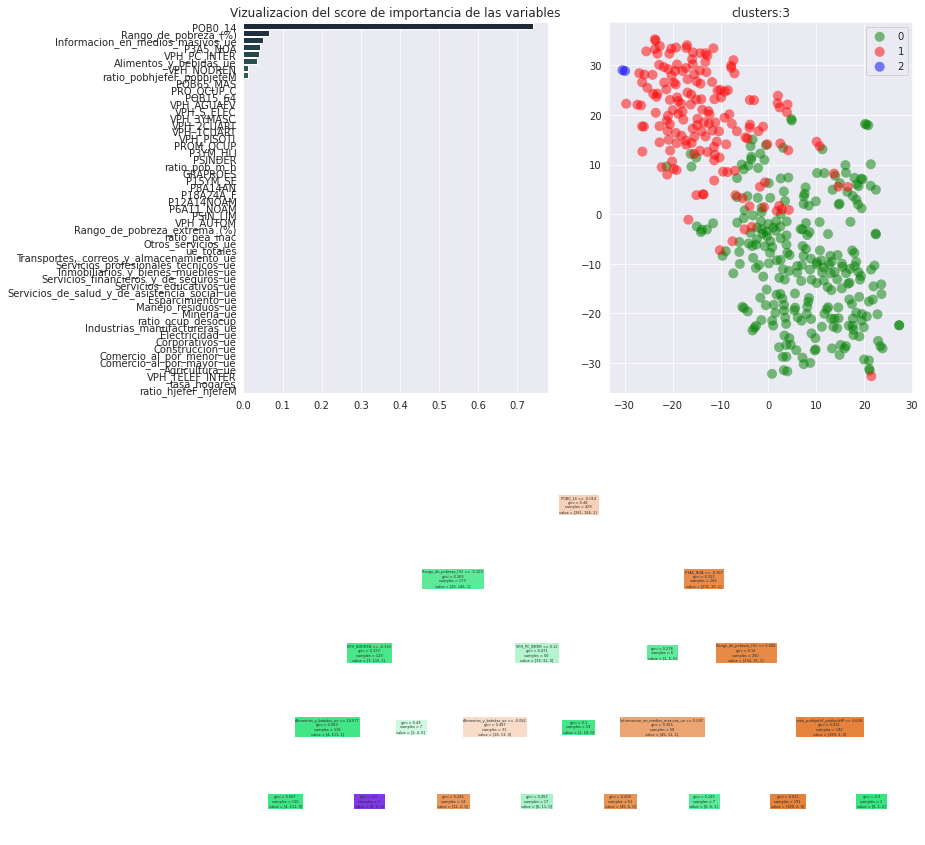

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9627039627039627
Confusion Matrix: 
 [[ 89   0   6   0]
 [  0 104   3   0]
 [  5   2 218   0]
 [  0   0   0   2]]


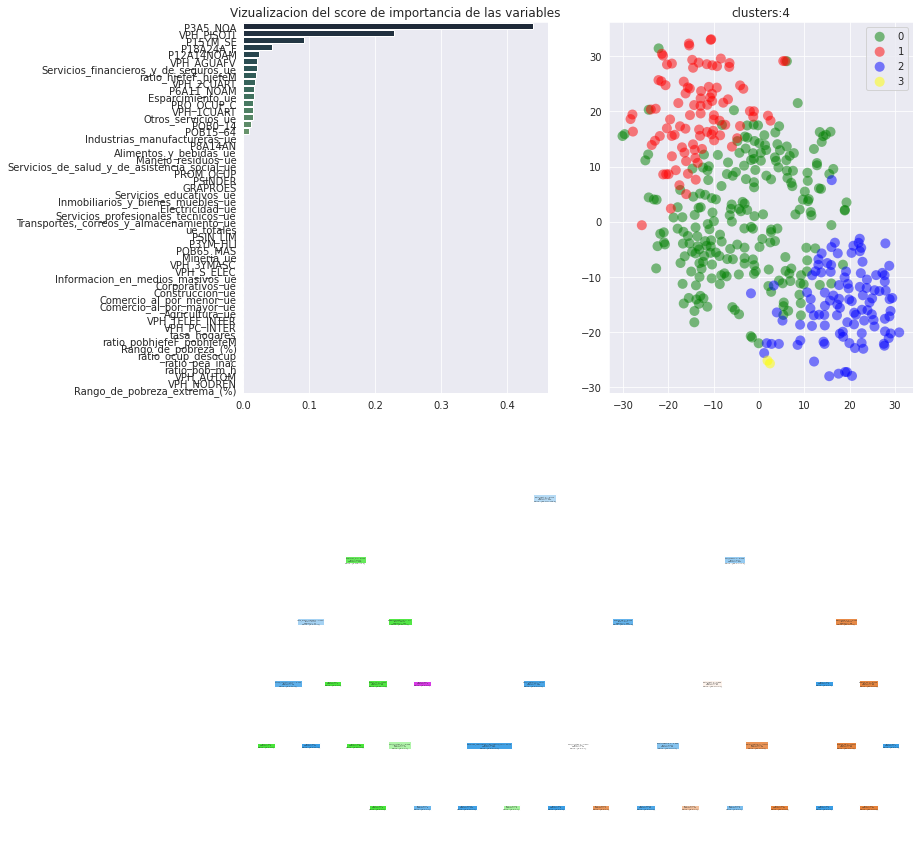

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9067599067599068
Confusion Matrix: 
 [[ 90   0  14   0   0]
 [  0  84  13   0   0]
 [  9   2 214   0   0]
 [  0   0   2   0   0]
 [  0   0   0   0   1]]


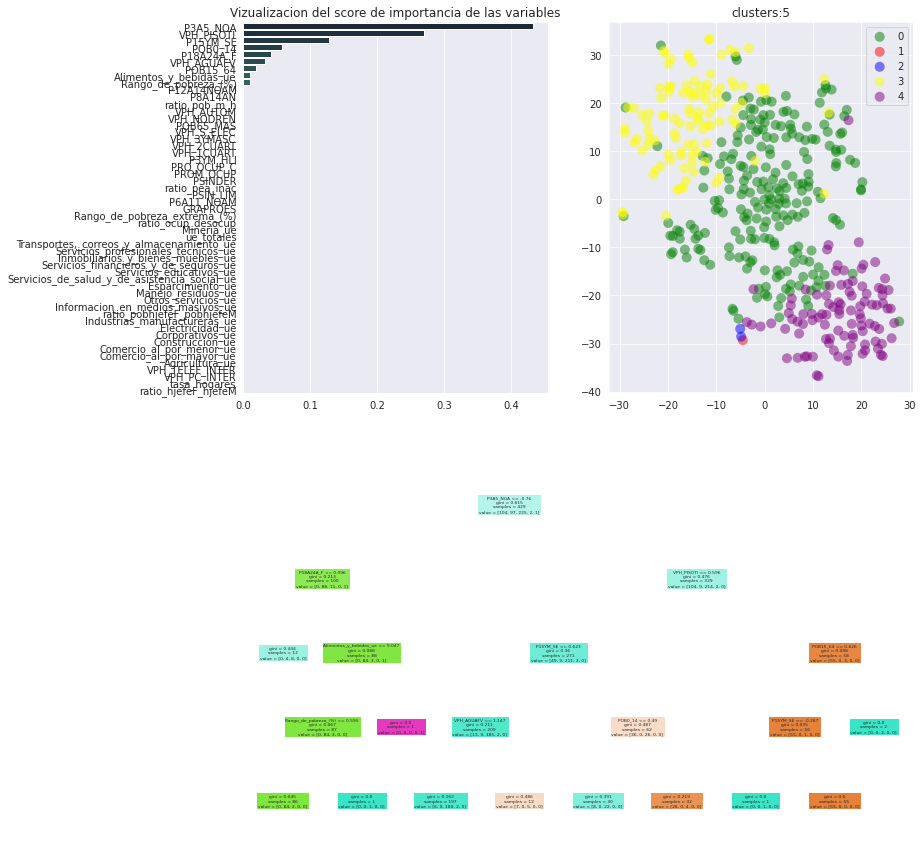

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.8974358974358975
Confusion Matrix: 
 [[ 87   0  18   0   0   0]
 [  0  95  10   0   0   0]
 [ 12   2 200   0   0   0]
 [  0   0   0   1   0   0]
 [  0   0   0   1   2   0]
 [  0   0   0   1   0   0]]


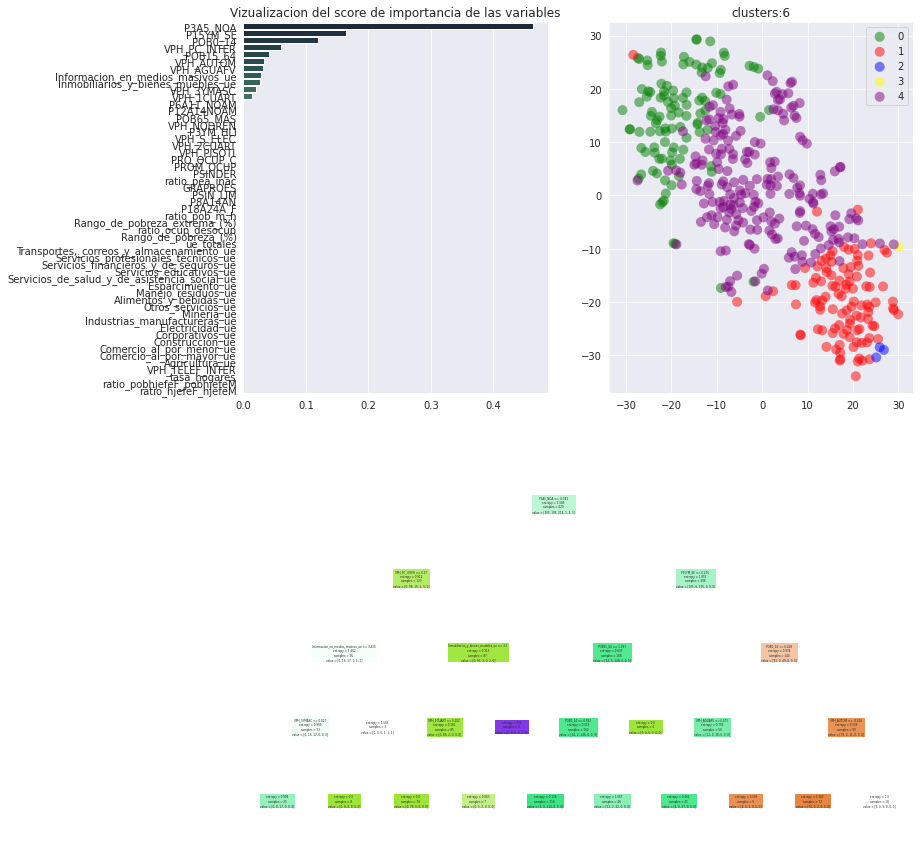

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9067599067599068
Confusion Matrix: 
 [[ 72   0   4   0   0   0   0]
 [  0  46   4   0   0   0   0]
 [ 16   0 187   0   0   0   0]
 [  0   0  14  72   0   0   0]
 [  1   0   0   0  11   0   0]
 [  0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   1]]


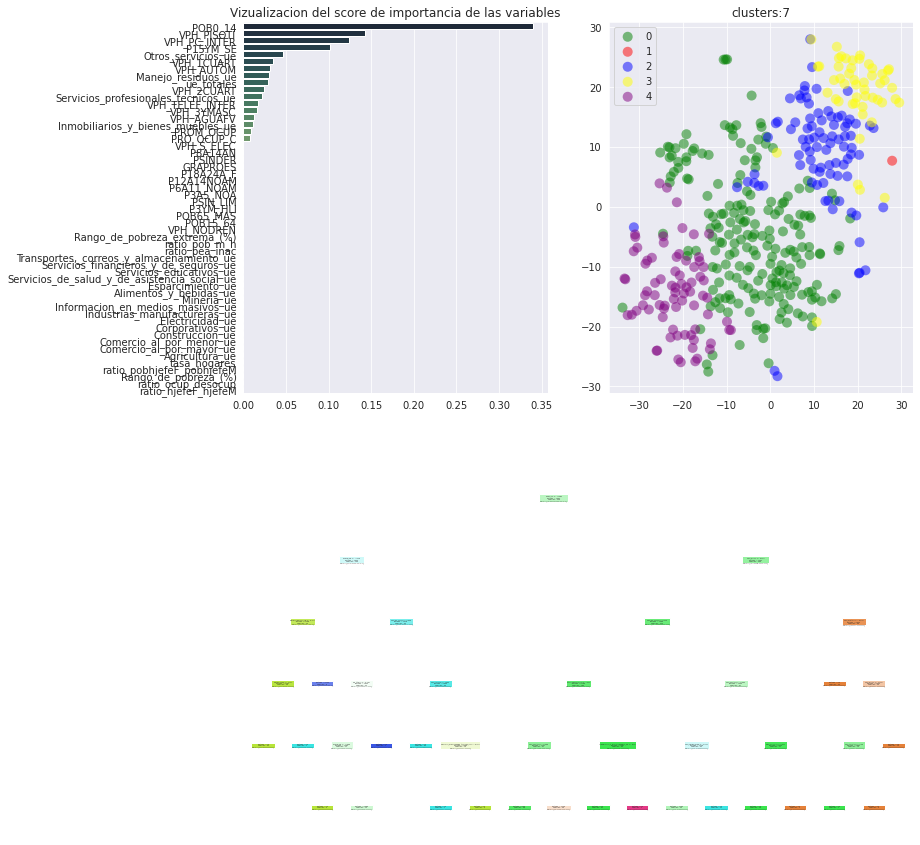

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9020979020979021
Confusion Matrix: 
 [[ 18   0   7   0   0   0   0   0]
 [  0  38   0   5   0   0   0   0]
 [  1   0 119   7   0   0   0   0]
 [  0   1  10 152   0   0   0   0]
 [  0   3   0   4  53   1   0   0]
 [  0   0   1   0   0   7   0   0]
 [  0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0]]


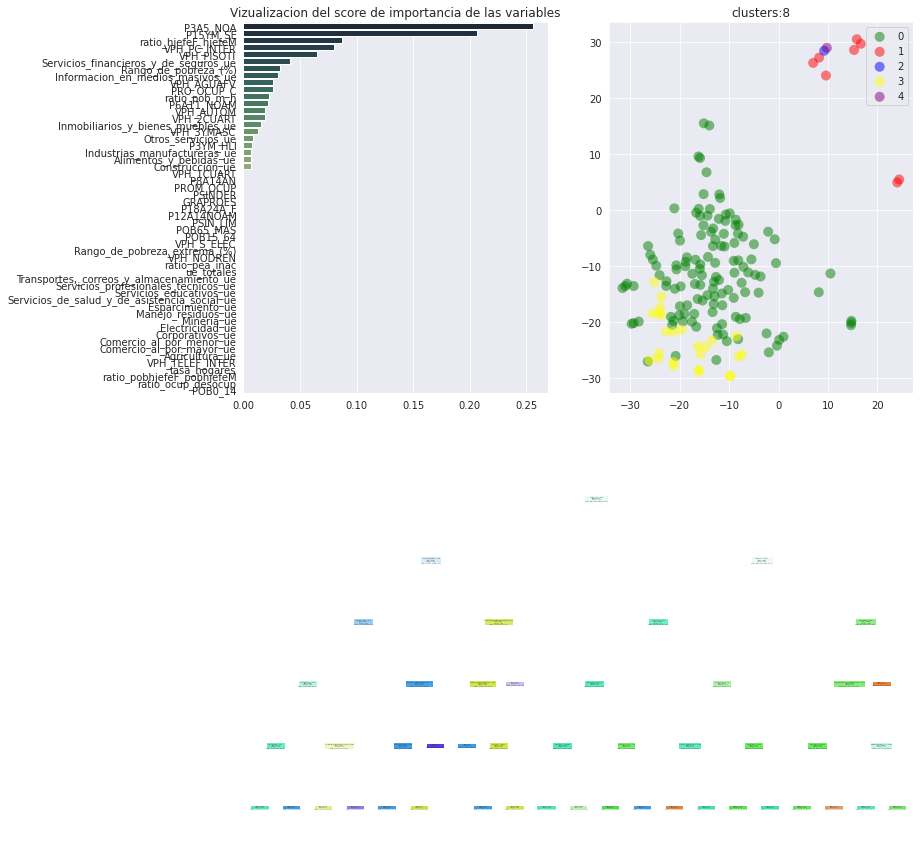

In [20]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]

feature_imp = []
for i, num_clus in enumerate(n_clusters):
    ##### K-means
    kmeans = KMeans(n_clusters=num_clus)
    #Fit our model
    kmeans.fit(ageb_data_scaled)
    #Find which cluster each data-point belongs to
    kmeans_clusters = kmeans.predict(ageb_data_scaled)

    ##### Decision tree
    X = ageb_data_scaled
    y = kmeans_clusters
    y, class_names = pd.factorize(y)
    #print('Classes:', class_names)
    classifier = DecisionTreeClassifier()
    #definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'max_depth': [2, 3, 4, 5], 
                        'min_samples_split': [5,10,20,50],
                        'criterion':['gini', 'entropy'],
                        'splitter':['random', 'best']}
    clf  = GridSearchCV(classifier, 
                        hyper_param_grid, 
                        scoring = "accuracy",
                        cv = 5, 
                        n_jobs = -1,)
                        #verbose = 3)
    y_pred = clf.fit(X, y).predict(X)
    print("Accuracy:",metrics.accuracy_score(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    print('Confusion Matrix: \n', cm)

    clf_best = clf.best_estimator_

    df = vizs(ageb_data_scaled, kmeans_clusters, clf_best, X, y)
    feature_imp.append(df)
    

La siguiente tabla muestra las variables y su importancia, según el número de clústers considerados. La última columna *'n'* indica en cuántos de los modelos la variable tiene una importancia diferente de cero.

In [21]:
feature_df = functools.reduce(lambda df1, df2: pd.concat([df1, df2],  axis=1), feature_imp)
feature_df.columns = [str(x)+'_clusters' for x in n_clusters]
feature_df['n'] = feature_df.iloc[:,1:].astype(bool).sum(axis=1)
feature_df.sort_values(['n'], ascending=False)

,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,n
P3A5_NOA,0.765906,0.042565,0.440033,0.433232,0.463873,0.000000,0.256260,5
VPH_AGUAFV,0.005909,0.000000,0.020755,0.031682,0.030870,0.012293,0.026362,5
POB0_14,0.141690,0.741040,0.010911,0.057847,0.119598,0.340301,0.000000,5
P15YM_SE,0.000000,0.000000,0.091988,0.127628,0.163361,0.101512,0.206810,5
VPH_PC_INTER,0.000000,0.040100,0.000000,0.000000,0.060781,0.123444,0.080489,4
VPH_PISOTI,0.000000,0.000000,0.228416,0.269731,0.000000,0.142487,0.064702,4
VPH_1CUART,0.000000,0.000000,0.014730,0.000000,0.014435,0.034957,0.000000,3
Informacion_en_medios_masivos_ue,0.000000,0.050571,0.000000,0.000000,0.028191,0.000000,0.030239,3
Otros_servicios_ue,0.000000,0.000000,0.014281,0.000000,0.000000,0.046793,0.008090,3
Alimentos_y_bebidas_ue,0.000000,0.035529,0.000000,0.009648,0.000000,0.000000,0.006885,3


#### 4. Dejando solo UE totales

Solo consideramos el total de las Unidades Económicas, sin los desagregados

In [22]:
uecon = ageb_data.columns[ageb_data.columns.str.contains('_ue')]
#uecon = list(set(uecon).difference({'Inmobiliarios_y_bienes_muebles_ue'}))
ageb_data.drop(columns = uecon, inplace=True)

# scale numeric variables
scaler = StandardScaler()
ageb_data_scaled = scaler.fit_transform(ageb_data)

Accuracy: 0.9463869463869464
Confusion Matrix: 
 [[261   7]
 [ 16 145]]
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 10, 'splitter': 'random'}


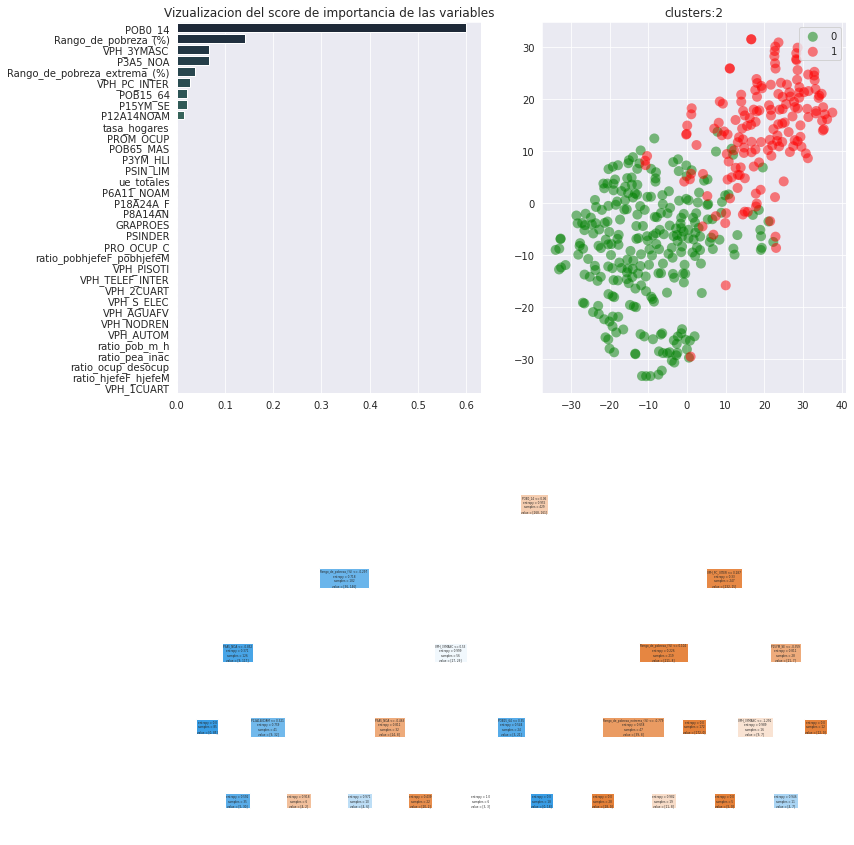

Accuracy: 0.9463869463869464
Confusion Matrix: 
 [[ 79   0   5]
 [  0 108   3]
 [ 14   1 219]]
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'splitter': 'best'}


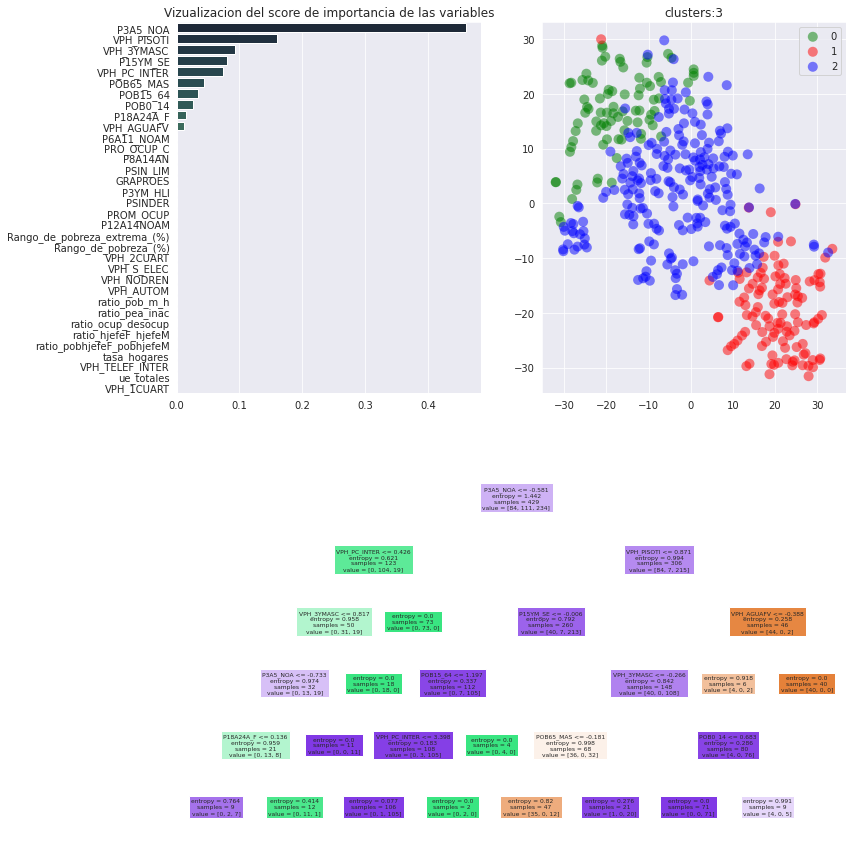

Accuracy: 0.916083916083916
Confusion Matrix: 
 [[ 69   6   3   0]
 [  4 107   3   0]
 [  4  11 124   0]
 [  0   5   0  93]]
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'splitter': 'best'}


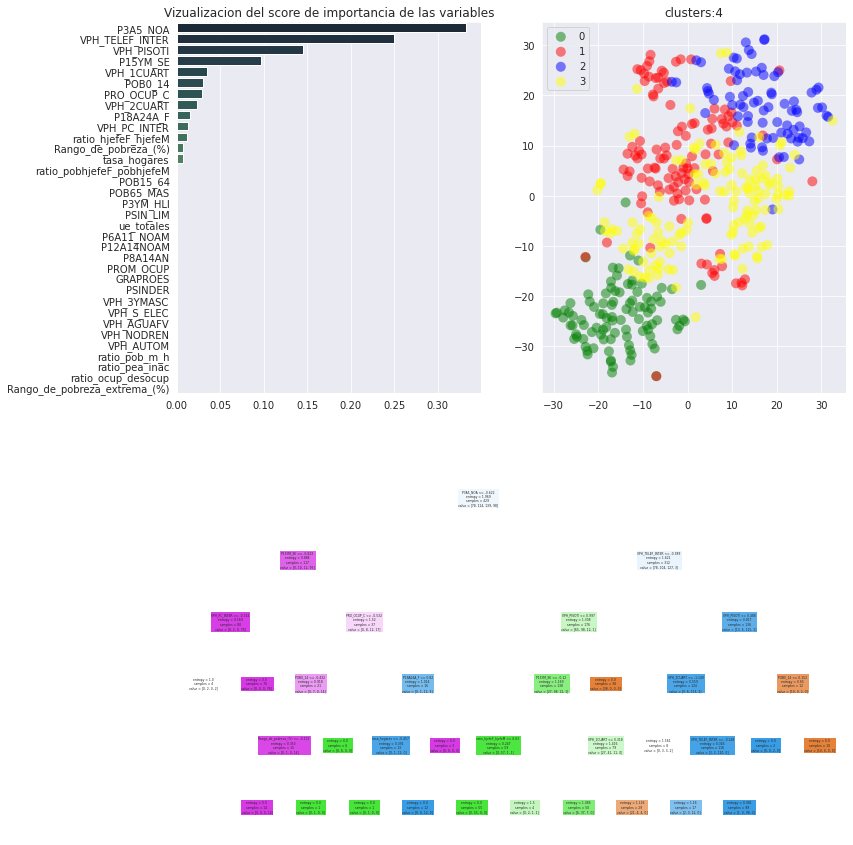

Accuracy: 0.8741258741258742
Confusion Matrix: 
 [[ 35   0   3   7   0]
 [  0  84   5   7   0]
 [  5   3  96  12   0]
 [  1   7   3 101   0]
 [  0   0   0   1  59]]
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 20, 'splitter': 'best'}


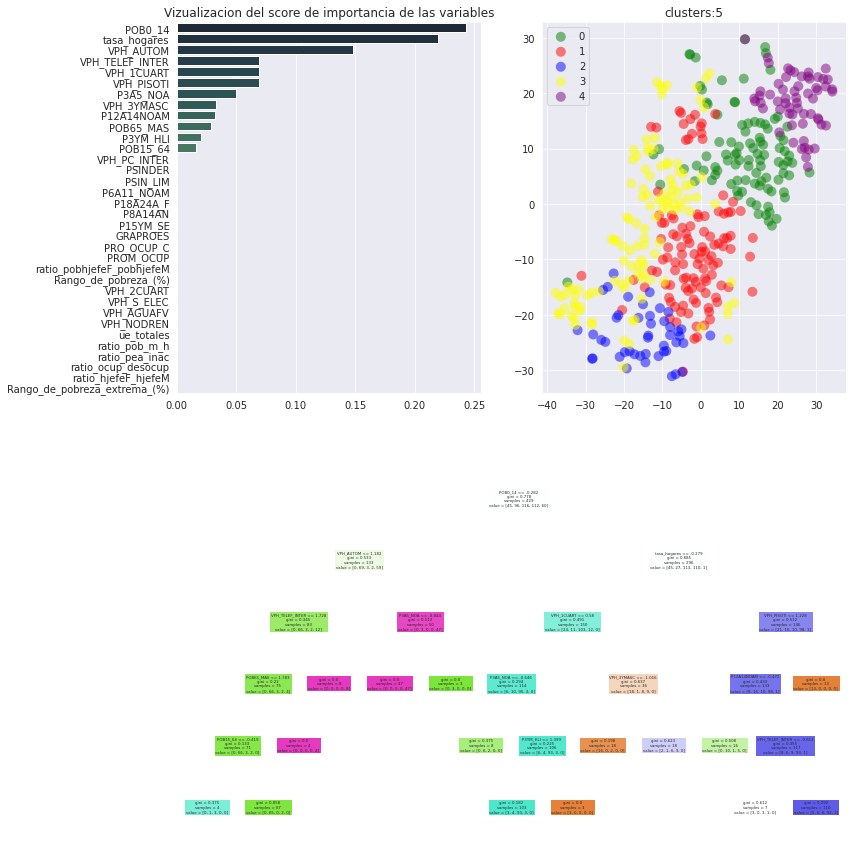

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9067599067599068
Confusion Matrix: 
 [[ 25   0   1   3   0   0]
 [  0 105  15   2   0   0]
 [  3   4 124   1   0   0]
 [  1   2   4  81   0   0]
 [  0   0   0   0  54   0]
 [  0   4   0   0   0   0]]
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'splitter': 'best'}


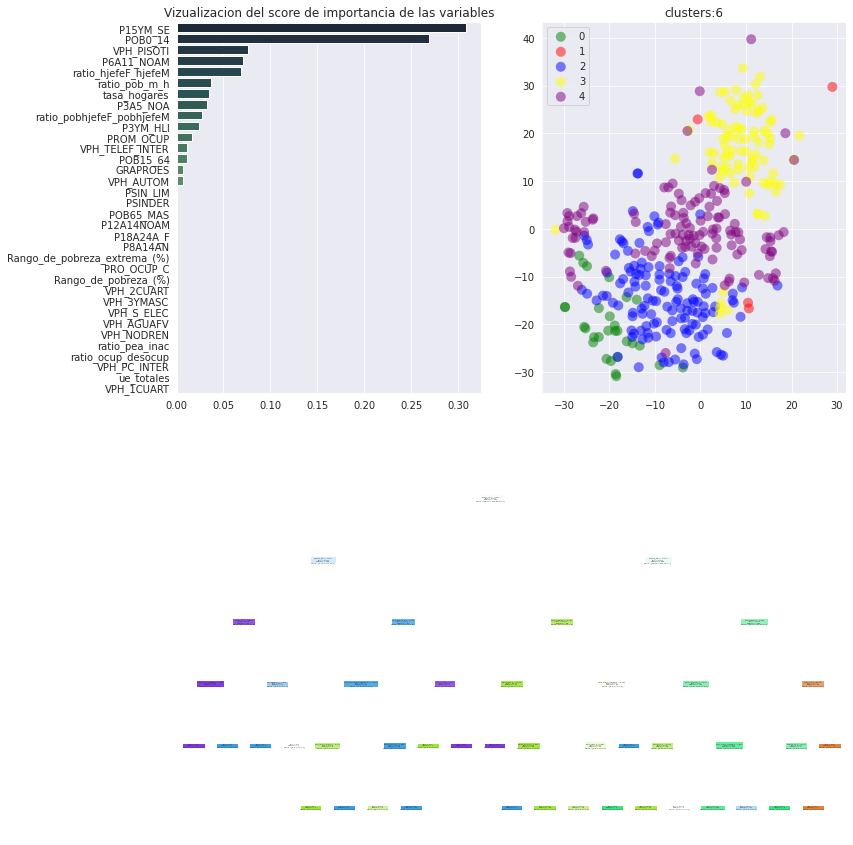

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.9067599067599068
Confusion Matrix: 
 [[ 24   1   1   3   0   0   0]
 [  0  95  10   1   0   0   0]
 [  3   5 136   3   0   0   0]
 [  1   4   2  76   0   1   0]
 [  0   1   0   0  13   0   0]
 [  0   0   0   2   0  45   0]
 [  0   2   0   0   0   0   0]]
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'splitter': 'best'}


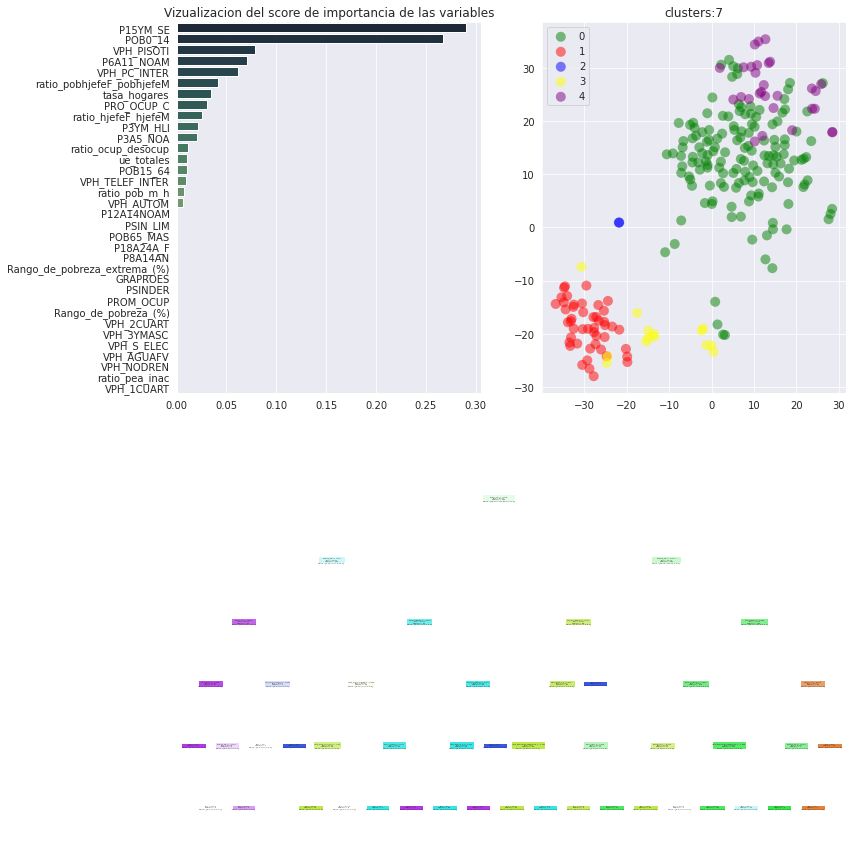

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.8158508158508159
Confusion Matrix: 
 [[  9   0   2   1   0   0   0   0]
 [  0  35   2   2   3   0   0   0]
 [  0   0  65   7   0   0   0   0]
 [  0   2  15 116   1   0   0   0]
 [  0   4   0   3  51   0   0   0]
 [  0   2   7   9   3  44   0   0]
 [  0   3   0   6   6   0  30   0]
 [  0   0   0   1   0   0   0   0]]
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 10, 'splitter': 'best'}


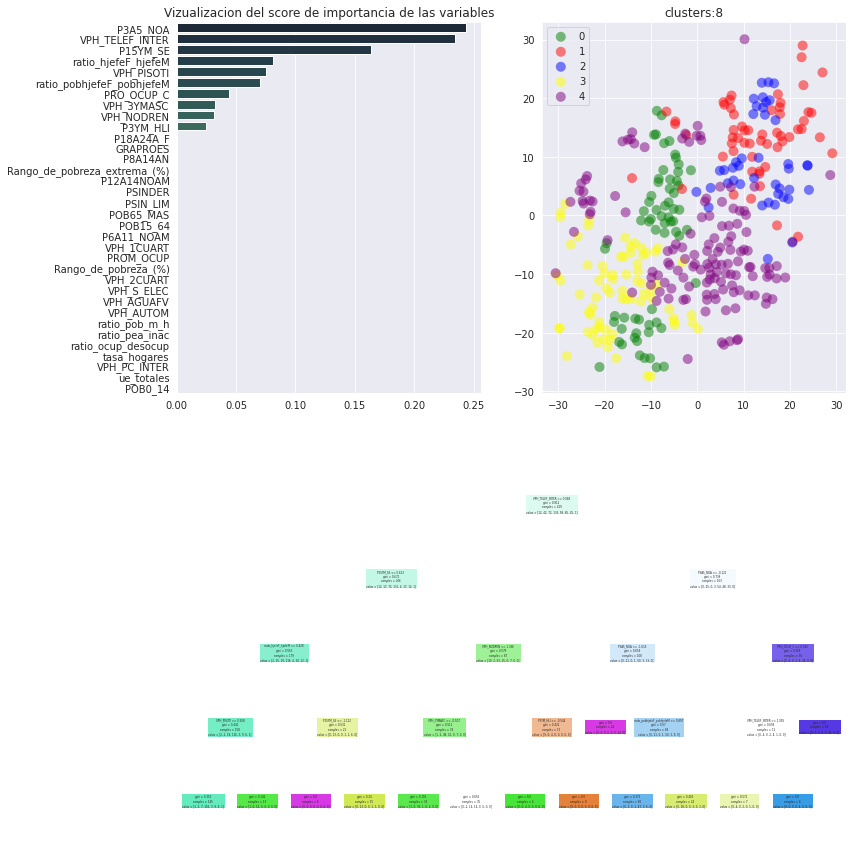

In [23]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]

feature_imp = []
for num_clus in n_clusters:
    ##### K-means
    kmeans = KMeans(n_clusters=num_clus)
    #Fit our model
    kmeans.fit(ageb_data_scaled)
    #Find which cluster each data-point belongs to
    kmeans_clusters = kmeans.predict(ageb_data_scaled)

    ##### Decision tree
    X = ageb_data_scaled
    y = kmeans_clusters
    y, class_names = pd.factorize(y)
    #print('Classes:', class_names)
    classifier = DecisionTreeClassifier()
    #definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'max_depth': [2, 3, 4, 5], 
                        'min_samples_split': [5,10,20,50],
                        'criterion':['gini', 'entropy'],
                        'splitter':['random', 'best']}
    clf  = GridSearchCV(classifier, 
                        hyper_param_grid, 
                        scoring = "accuracy",
                        cv = 5, 
                        n_jobs = -1,)
                        #verbose = 3)
    y_pred = clf.fit(X, y).predict(X)
    print("Accuracy:",metrics.accuracy_score(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    print('Confusion Matrix: \n', cm)
    print(clf.best_params_)
    clf_best = clf.best_estimator_

    df = vizs(ageb_data_scaled, kmeans_clusters, clf_best, X, y)
    feature_imp.append(df)

In [24]:
feature_df2 = functools.reduce(lambda df1, df2: pd.concat([df1, df2],  axis=1), feature_imp)
feature_df2.columns = [str(x)+'_clusters' for x in n_clusters]
feature_df2['n'] = feature_df2.iloc[:,1:].astype(bool).sum(axis=1)
feature_df2.sort_values(['n'], ascending=False)

,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,n
P3A5_NOA,0.067584,0.461351,0.332888,0.050011,0.032246,0.020391,0.243913,6
VPH_PISOTI,0.000000,0.160434,0.145166,0.069247,0.075890,0.078318,0.074978,6
POB0_14,0.600099,0.025912,0.030796,0.243328,0.269689,0.266844,0.000000,5
P15YM_SE,0.020969,0.080417,0.096910,0.000000,0.309090,0.290781,0.163188,5
VPH_TELEF_INTER,0.000000,0.000000,0.249827,0.069391,0.011410,0.009610,0.234074,5
ratio_hjefeF_hjefeM,0.000000,0.000000,0.012160,0.000000,0.068755,0.025929,0.080902,4
POB15_64,0.021422,0.033334,0.000000,0.016511,0.010867,0.010678,0.000000,4
tasa_hogares,0.000000,0.000000,0.007190,0.219332,0.034440,0.034750,0.000000,4
P3YM_HLI,0.000000,0.000000,0.000000,0.020743,0.023564,0.021743,0.024574,4
VPH_3YMASC,0.067983,0.093654,0.000000,0.033014,0.000000,0.000000,0.032729,3


Seleccionando 3 clústers, el árbol de decisión queda de la siguiente manera:

Accuracy: 0.9487179487179487
Confusion Matrix: 
 [[ 82   0   1]
 [  0 108   3]
 [ 17   1 217]]
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'splitter': 'best'}


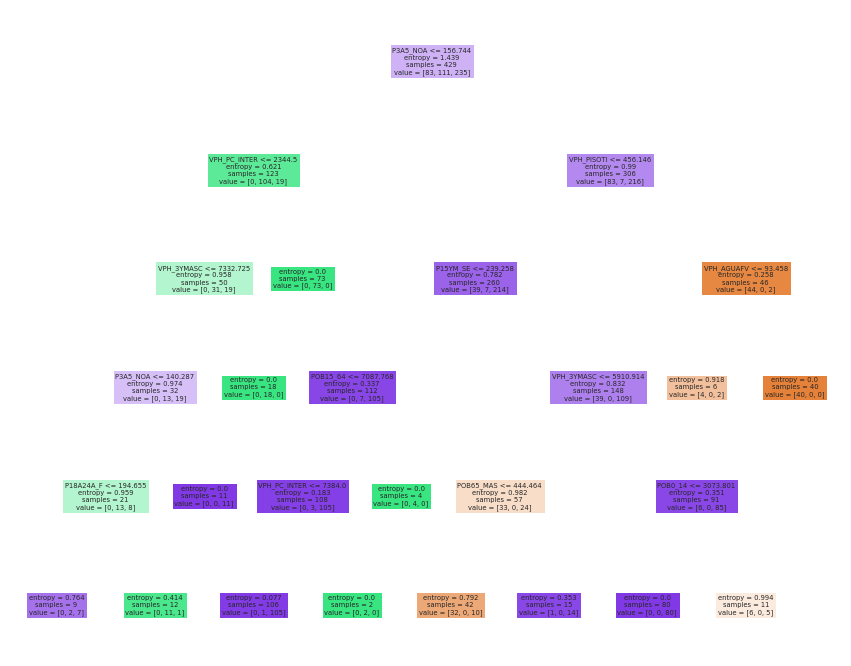

In [25]:
num_clus = 3

##### K-means
kmeans = KMeans(n_clusters=num_clus)
#Fit our model
kmeans.fit(ageb_data_scaled)
#Find which cluster each data-point belongs to
kmeans_clusters = kmeans.predict(ageb_data_scaled)

##### Decision tree
X = ageb_data
y = kmeans_clusters
#y, class_names = pd.factorize(y)
#print('Classes:', class_names)
classifier = DecisionTreeClassifier()
#definicion de los hiperparametros que queremos probar
hyper_param_grid = {'max_depth': [2, 3, 4, 5], 
                    'min_samples_split': [5,10,20,50],
                    'criterion':['gini', 'entropy'],
                    'splitter':['random', 'best']}
clf  = GridSearchCV(classifier, 
                    hyper_param_grid, 
                    scoring = "accuracy",
                    cv = 5, 
                    n_jobs = -1,)
                    #verbose = 3)
y_pred = clf.fit(X, y).predict(X)
print("Accuracy:",metrics.accuracy_score(y, y_pred))
cm = confusion_matrix(y, y_pred)
print('Confusion Matrix: \n', cm)

clf_best = clf.best_estimator_
fig = plt.figure(figsize=(15,12))
_ = tree.plot_tree(clf_best,
                   feature_names=ageb_data.columns.to_list(),  
                   #class_names=["C0","C1", "C2"],
                   filled=True)
print(clf.best_params_)

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# DOT data
dot_data = export_graphviz(clf_best, out_file=None, 
                           feature_names=ageb_data.columns.to_list(),  
                           class_names=["C0","C1", "C3"],
                           impurity=True,
                           filled=True)

In [ ]:
# Draw graph
graph = graphviz.Source(dot_data)
graph